Script to perform probabilistic hazard assessments on space weather GIC data from NERC



In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob


from datetime import datetime, time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


import geopandas as gpd
from shapely.geometry import Point




In [106]:
from IPython.display import IFrame

# Display the HTML file in an iframe
IFrame(src="Reliability Coordination Regions.html", width=800, height=600)

In [2]:
# Load regions
regions_gdf = gpd.read_file("/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/NERC_Reliability_Coordinators.geojson")
# Ensure the CRS is WGS84 (EPSG:4326)
if regions_gdf.crs is None or regions_gdf.crs.to_string() != "EPSG:4326":
    print('converting to EPSG: 4326')
    regions_gdf = regions_gdf.to_crs("EPSG:4326")


In [90]:

# Histogram initializations
    # Define the histogram bins between -50 and 50
bins = np.linspace(-50, 50, num=101)  # 101 edges for 100 bins
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting later
    # Initialize an empty dictionary to store histograms for each region
histogram_data = {}
extreme_value_data = {}

# Load integrated data files
integrated_data_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/'
files = glob.glob( os.path.join(integrated_data_directory,'*.csv') )


# Identify an event (later can loop over these to grow statistics)
event_idx = 17

for f in files:#[event_idx:event_idx+1]:

    # read in the numerical data for the sensors in this event
    df = pd.read_csv(f,index_col=False)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0')
    
    # read in the lat-long values for the sensors in this event
    print('\n\n\n\n----------------------------\nworking on event: {}'.format(f[97:-4])) #f.find('event')
    print('\t--->{}'.format(f))
    file_sensor_locations = os.path.join('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/','risk-resiliency-spwx','data',f[97:-4],'GIC','gic_monitors.csv')

    print('\t--->{}'.format(file_sensor_locations))
    df_sensor_locations = pd.read_csv(file_sensor_locations)
    df_sensor_locations[' Longitude'] = df_sensor_locations[' Longitude'] * -1.

    # Convert sensor DataFrame to GeoDataFrame
    gdf_sensor_locations = gpd.GeoDataFrame(
                                df_sensor_locations,
                                geometry=[Point(xy) for xy in zip(df_sensor_locations[" Longitude"], df_sensor_locations[" Latitude"])],
                                crs="EPSG:4326"
                                )
    


    # Step 3: Perform Spatial Join with NERC Reliability Regions
    sensor_locations_with_regions = gpd.sjoin(gdf_sensor_locations, regions_gdf, how="left", predicate="within")
    sensor_locations_with_regions = sensor_locations_with_regions.reset_index()
    sensor_locations_with_regions = sensor_locations_with_regions.drop_duplicates(subset="index",keep="first")
    sensor_locations_with_regions = sensor_locations_with_regions.drop(columns=["index"])

    df_sensor_locations["Region"] = sensor_locations_with_regions["NAME"]

    grouped = df_sensor_locations.groupby('Region')
    for region, region_data in grouped:

        # Initialize histogram for this region if not already present
        if region not in histogram_data:
            histogram_data[region] = np.zeros(len(bins) - 1)
            extreme_value_data[region] = []#np.array(())
        
        # Loop over each 'Device ID' in the region
        for device_id, device_data in region_data.groupby('Device ID'):
            # Get counts for this 'Device ID' in the histogram bins
            try:
                device_data = df[str(device_id)]
            except:
                print('missing device ID = {}, continuing...'.format(device_id))
                continue
            counts, _ = np.histogram(device_data.values, bins=bins)
            max_val_device = np.nanmax(device_data.values)
            
            # Add these counts to the region's histogram
            histogram_data[region] += counts
            extreme_value_data[region].append(max_val_device)

    







----------------------------
working on event: event_20150919
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/integrated_data_event_20150919.csv
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20150919/GIC/gic_monitors.csv
missing device ID = 10115, continuing...
missing device ID = 10116, continuing...
missing device ID = 10119, continuing...
missing device ID = 10120, continuing...
missing device ID = 10121, continuing...
missing device ID = 10293, continuing...
missing device ID = 10294, continuing...
missing device ID = 10295, continuing...
missing device ID = 10296, continuing...
missing device ID = 10360, continuing...
missing device ID = 10254, continuing...
missing device ID = 10291, continuing...
missing device ID = 10292, continuing...
missing device ID = 10378, continuing...
missing device ID = 10112, continuing...
missing device ID = 10224, continuing...
missing device ID = 10325

### Probabilistic Hazard Assessment

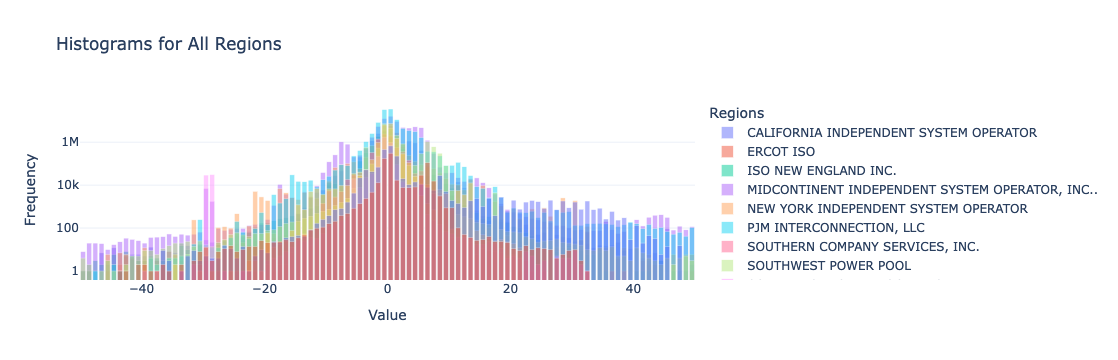

In [60]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for each region
for region, histogram in histogram_data.items():
    fig.add_trace(
        go.Bar(
            x=bin_centers, 
            y=histogram,
            name=region,
            opacity=0.5  # 50% transparent bars
        )
    )

# Update layout to add interactivity and labels
fig.update_layout(
    title="Histograms for All Regions",
    xaxis_title="Value",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay bars instead of stacking
    legend_title="Regions",
    template="plotly_white"
)
fig.update_yaxes(type="log")

# Show the interactive plot
fig.show()

In [72]:
histogram_data

{'CALIFORNIA INDEPENDENT SYSTEM OPERATOR': array([0.000000e+00, 2.000000e+00, 0.000000e+00, 7.000000e+00,
        2.000000e+00, 1.200000e+01, 7.000000e+00, 5.000000e+00,
        6.000000e+00, 6.000000e+00, 5.000000e+00, 1.300000e+01,
        3.000000e+00, 1.000000e+01, 8.000000e+00, 7.000000e+00,
        2.000000e+01, 1.500000e+01, 1.000000e+01, 1.800000e+01,
        2.800000e+01, 2.200000e+01, 2.100000e+01, 2.400000e+01,
        3.900000e+01, 4.400000e+01, 3.800000e+01, 6.900000e+01,
        4.900000e+01, 9.300000e+01, 8.400000e+01, 9.600000e+01,
        1.330000e+02, 1.800000e+02, 2.200000e+02, 2.920000e+02,
        9.050000e+02, 2.642000e+03, 4.632000e+03, 5.923000e+03,
        1.018800e+04, 2.761200e+04, 4.606200e+04, 1.870700e+04,
        3.645900e+04, 2.034900e+05, 4.813280e+05, 1.173918e+06,
        2.545246e+06, 1.765060e+06, 3.234344e+06, 2.168103e+06,
        8.642170e+05, 1.132831e+06, 9.266880e+05, 4.160780e+05,
        8.006600e+04, 1.815100e+04, 9.332000e+03, 2.856000e+03

### Extreme Value Analyses

In [68]:
from scipy.stats import genextreme, genpareto
from pyextremes import get_return_periods

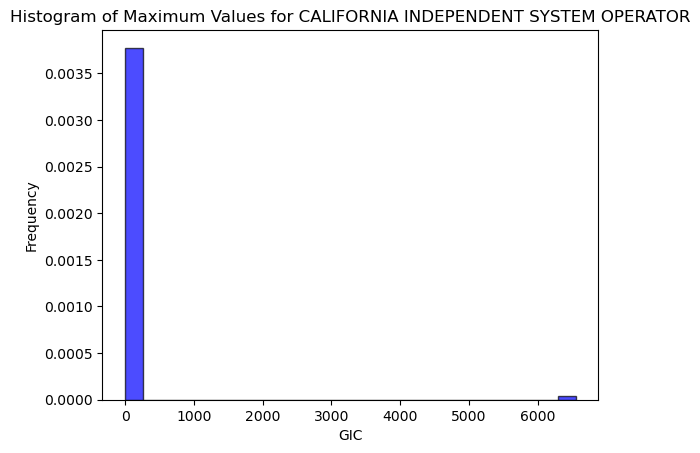

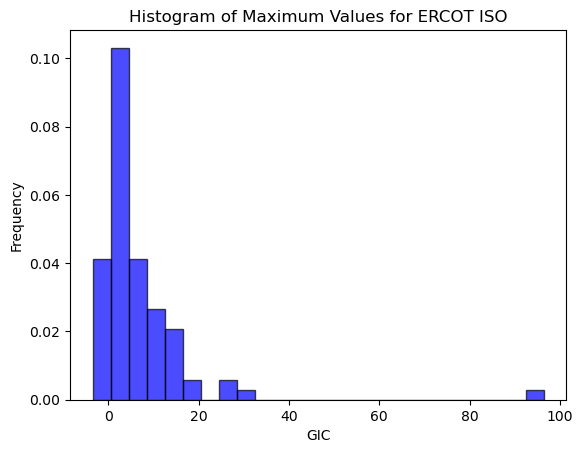

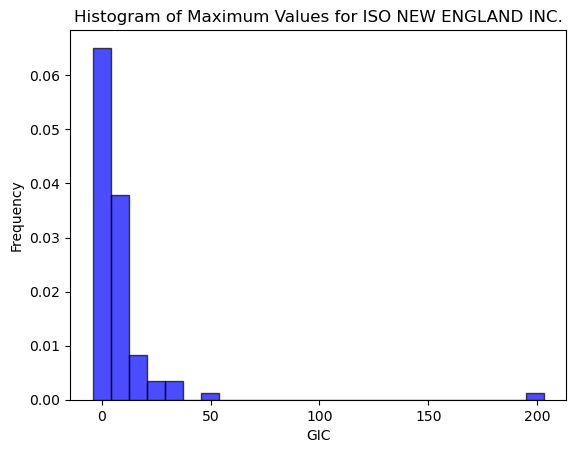

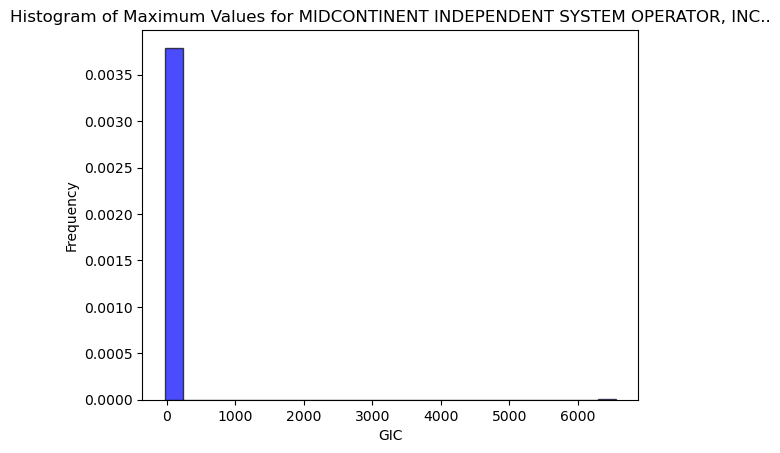

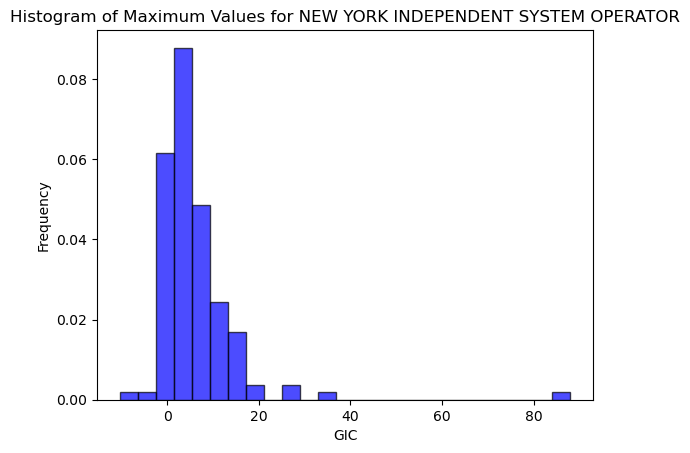

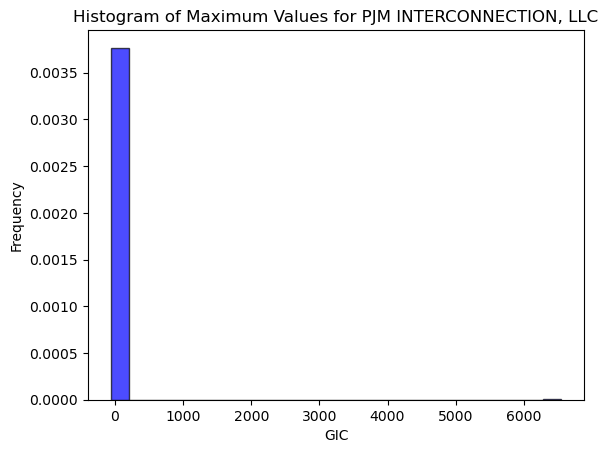

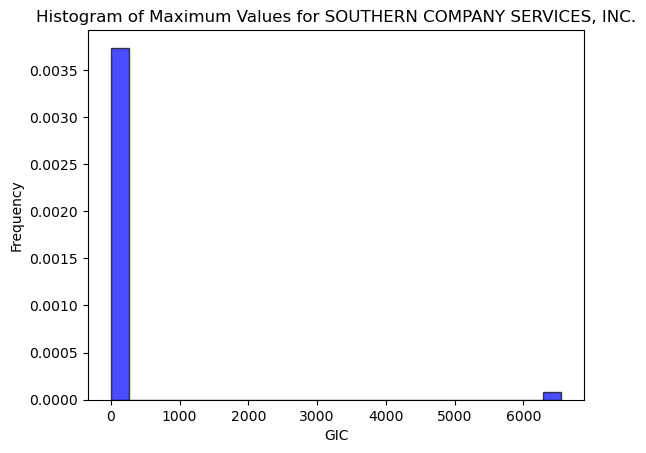

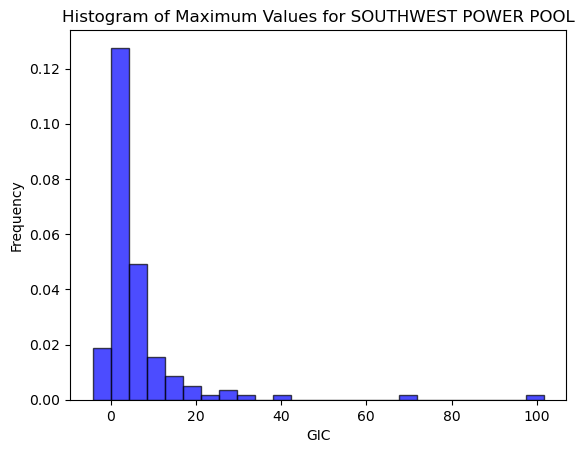

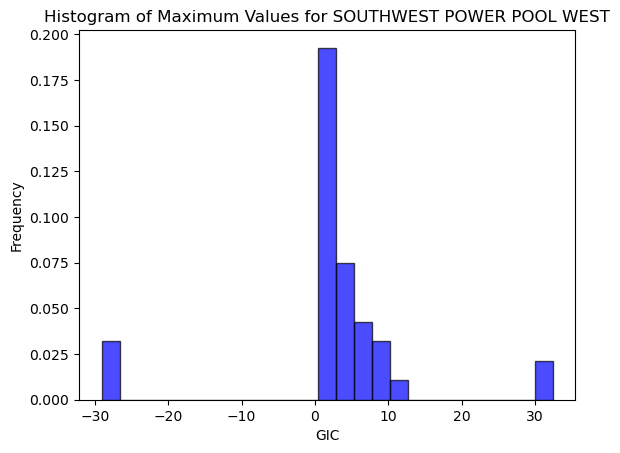

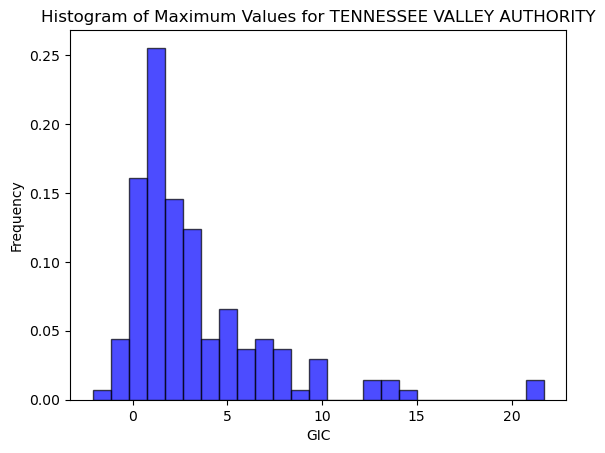

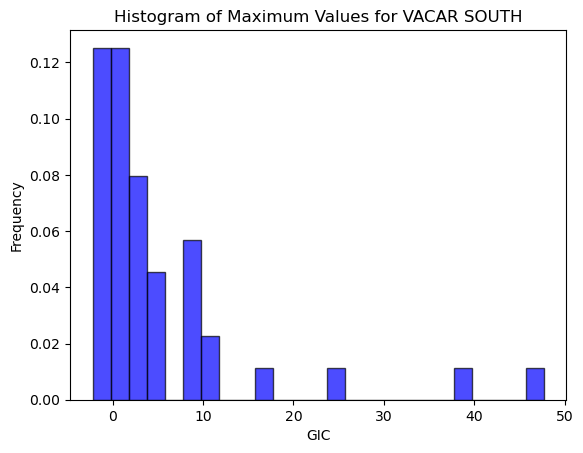

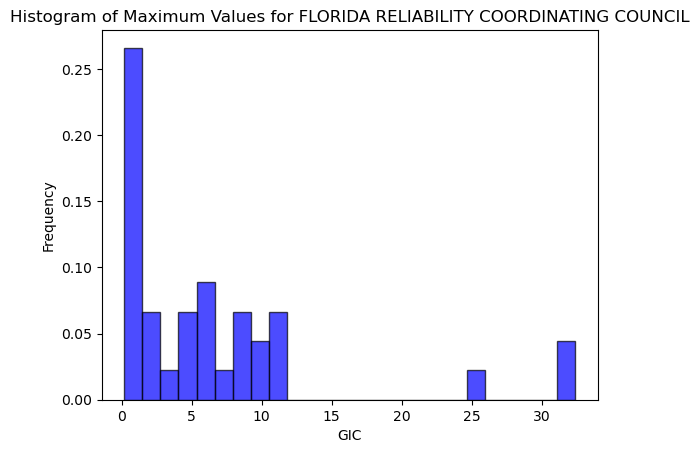

In [93]:
for region, data in extreme_value_data.items():
    plt.figure()
    plt.hist
    plt.hist(data, bins=25, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Maximum Values for '+region)
    plt.xlabel('GIC')
    plt.ylabel('Frequency')
    plt.show()



GEV Parameters for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR:
Shape: -0.545915655042492, Location: 2.19419585391066, Scale: 5.193965821200276


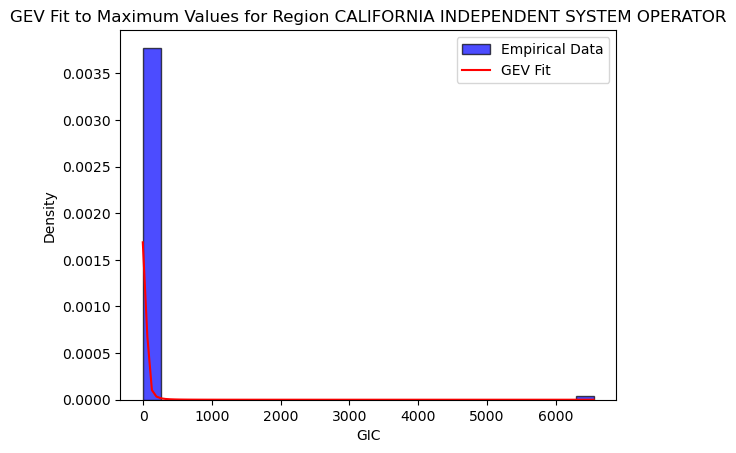

GEV Parameters for region ERCOT ISO:
Shape: -0.25972529136515776, Location: 2.431057750853814, Scale: 4.188129755388918


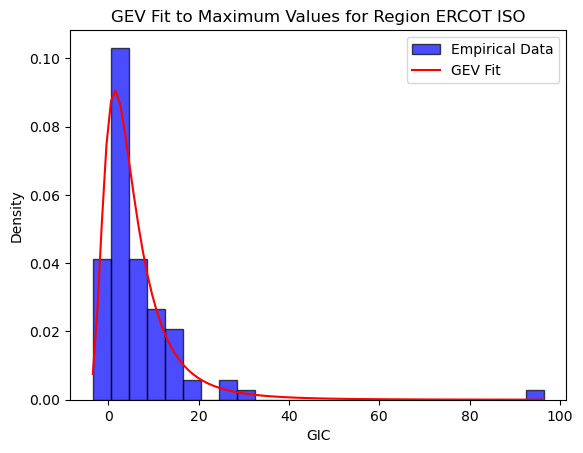

GEV Parameters for region ISO NEW ENGLAND INC.:
Shape: -0.33025989985495374, Location: 2.4060927124234723, Scale: 4.596812000689127


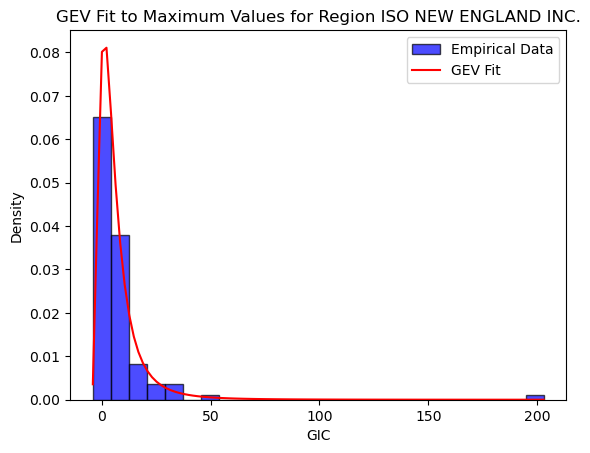

GEV Parameters for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..:
Shape: -0.2919607685956797, Location: -5.589727735984045, Scale: 10.146564882986478


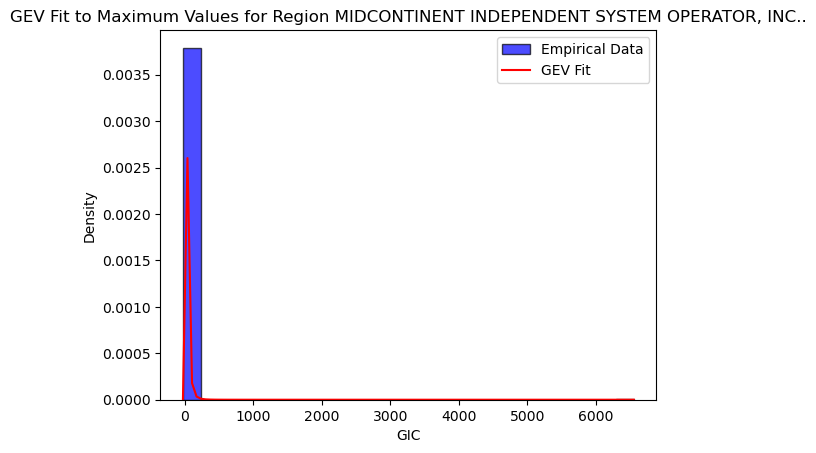

GEV Parameters for region NEW YORK INDEPENDENT SYSTEM OPERATOR:
Shape: -0.048969445419361386, Location: 2.9588506314789047, Scale: 5.044737670272368


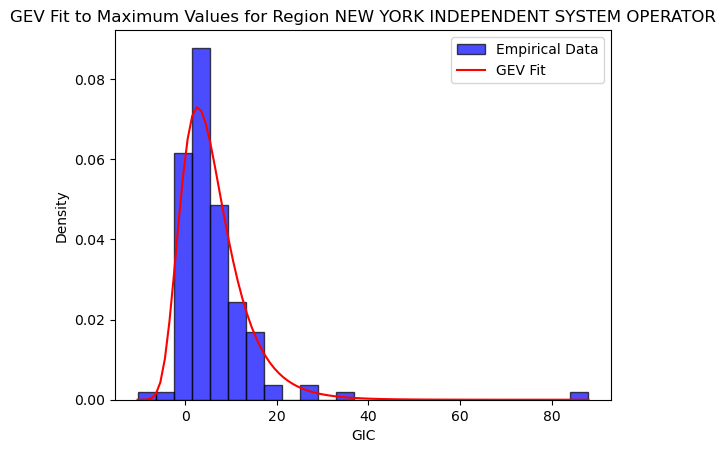

GEV Parameters for region PJM INTERCONNECTION, LLC:
Shape: -3.320840700943945, Location: -64.58720594225846, Scale: 1.046243850269517


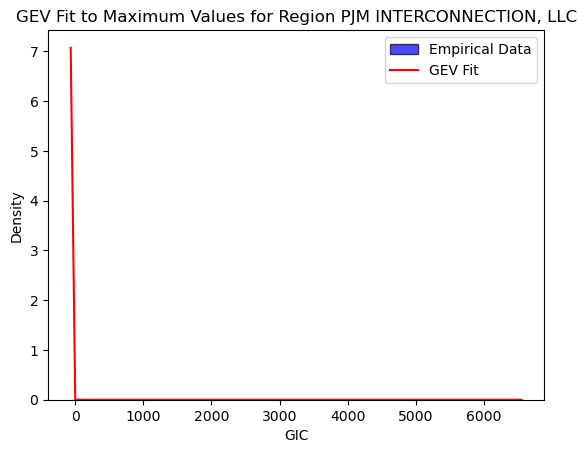

GEV Parameters for region SOUTHERN COMPANY SERVICES, INC.:
Shape: -0.5911169472458598, Location: 0.033527501716719366, Scale: 4.128937444374657


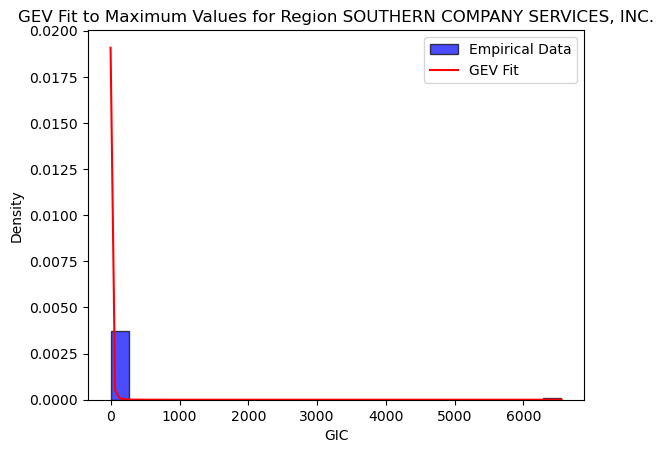

GEV Parameters for region SOUTHWEST POWER POOL:
Shape: -0.286847318694201, Location: 1.9952087312935034, Scale: 3.613475159852846


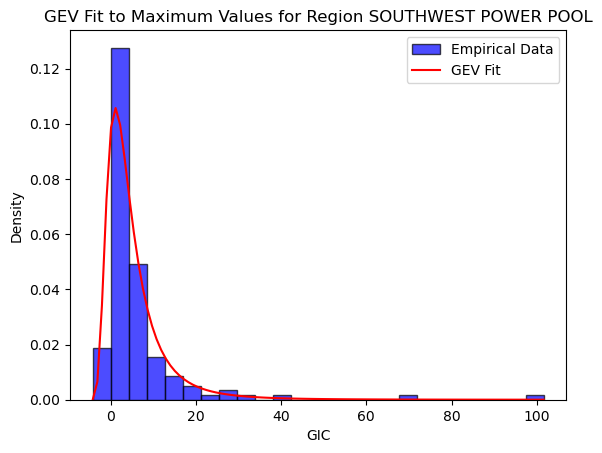

GEV Parameters for region SOUTHWEST POWER POOL WEST:
Shape: 2.8817303541626957, Location: 30.678621715226953, Scale: 4.960548054227003


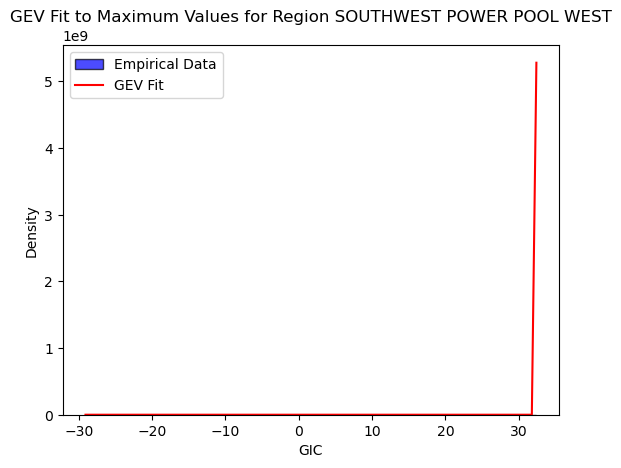

GEV Parameters for region TENNESSEE VALLEY AUTHORITY:
Shape: -0.20324603246884881, Location: 1.6015346062522084, Scale: 2.0451808431674863


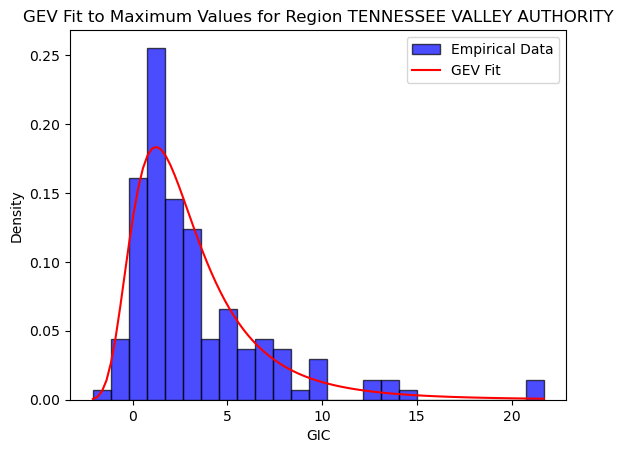

GEV Parameters for region VACAR SOUTH:
Shape: -0.526097795835019, Location: 0.8300183925186342, Scale: 2.9031324271763133


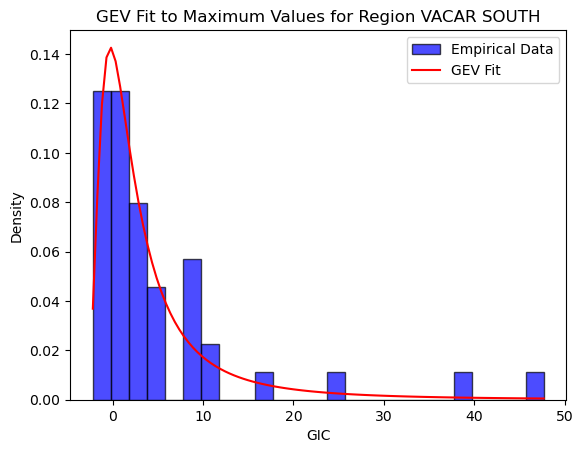

GEV Parameters for region FLORIDA RELIABILITY COORDINATING COUNCIL:
Shape: -1.0743756905096835, Location: 1.7843261961663621, Scale: 2.1497375765202493


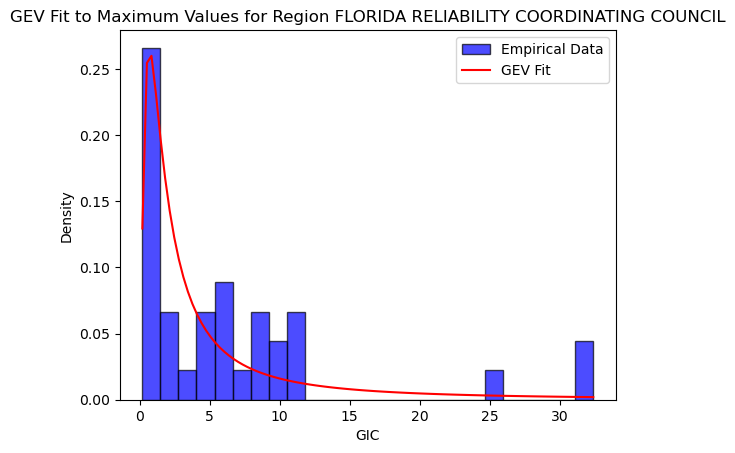

In [100]:
extreme_value_fits = {}
for region, e in extreme_value_data.items():

    if region not in extreme_value_fits:
        extreme_value_fits[region] = 0
    # Fit a Generalized Extreme Value (GEV) distribution
    gev_params = genextreme.fit(e)
    
    # Extract GEV parameters
    shape, loc, scale = gev_params
    print(f"GEV Parameters for region {region}:\nShape: {shape}, Location: {loc}, Scale: {scale}")
    extreme_value_fits[region] = [shape,loc,scale]
    
    # Generate x values for plotting
    x = np.linspace(min(e), max(e), 100)
    
    # Compute the PDF of the fitted GEV distribution
    pdf = genextreme.pdf(x, shape, loc=loc, scale=scale)
    
    # Plot histogram and GEV PDF
    plt.hist(e, bins=25, density=True, alpha=0.7, color='blue', edgecolor='black', label='Empirical Data')
    plt.plot(x, pdf, 'r-', label='GEV Fit')
    plt.title('GEV Fit to Maximum Values for Region '+region)
    plt.xlabel('GIC')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    

Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 10 years, Return Level: 25.18
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 20 years, Return Level: 40.83
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 50 years, Return Level: 72.75
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 100 years, Return Level: 109.90


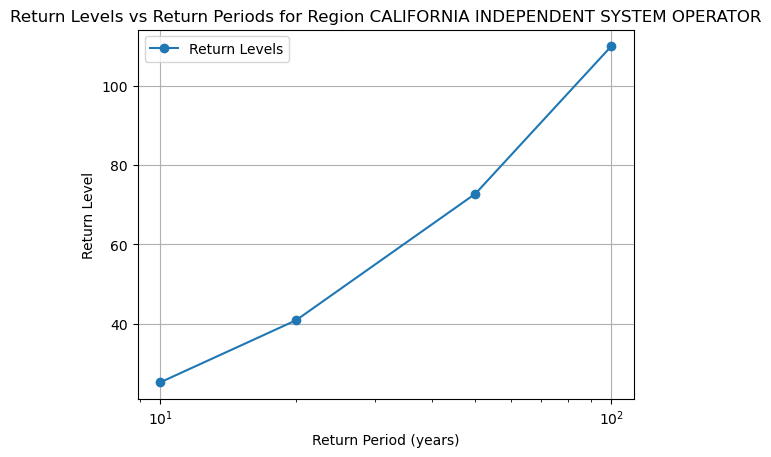

Return Period for region ERCOT ISO: 10 years, Return Level: 15.24
Return Period for region ERCOT ISO: 20 years, Return Level: 21.18
Return Period for region ERCOT ISO: 50 years, Return Level: 30.73
Return Period for region ERCOT ISO: 100 years, Return Level: 39.56


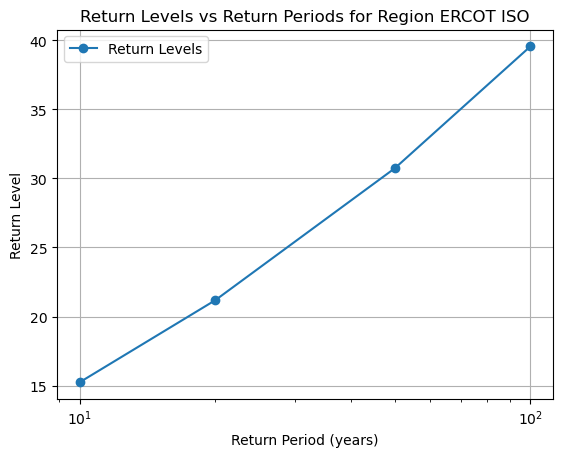

Return Period for region ISO NEW ENGLAND INC.: 10 years, Return Level: 17.75
Return Period for region ISO NEW ENGLAND INC.: 20 years, Return Level: 25.61
Return Period for region ISO NEW ENGLAND INC.: 50 years, Return Level: 38.98
Return Period for region ISO NEW ENGLAND INC.: 100 years, Return Level: 52.08


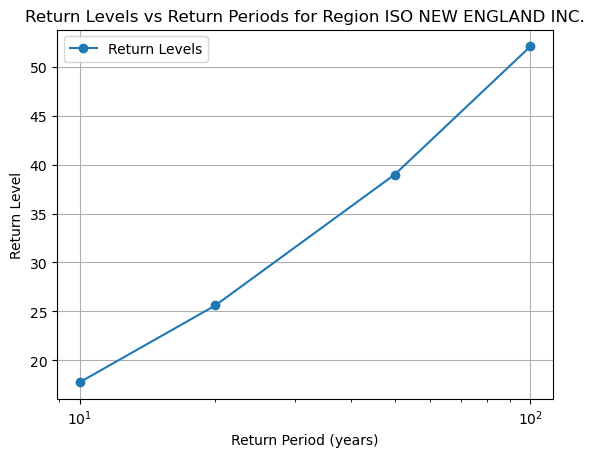

Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 10 years, Return Level: 26.70
Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 20 years, Return Level: 42.38
Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 50 years, Return Level: 68.24
Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 100 years, Return Level: 92.79


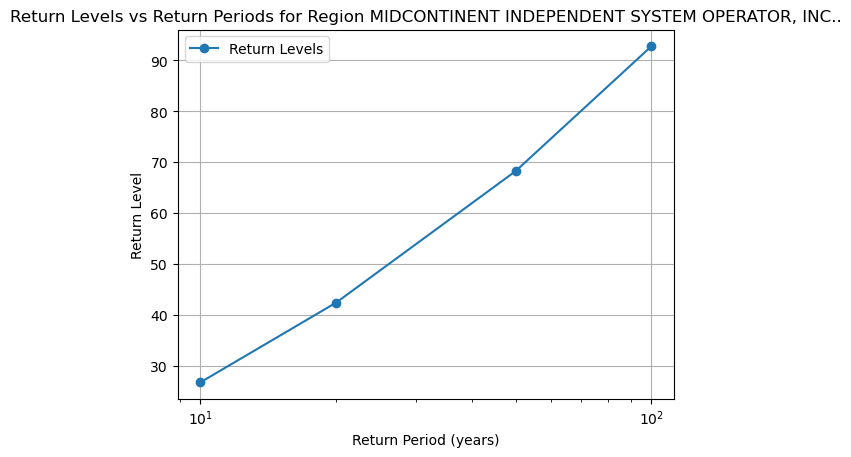

Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 10 years, Return Level: 14.96
Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 20 years, Return Level: 19.09
Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 50 years, Return Level: 24.65
Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 100 years, Return Level: 28.99


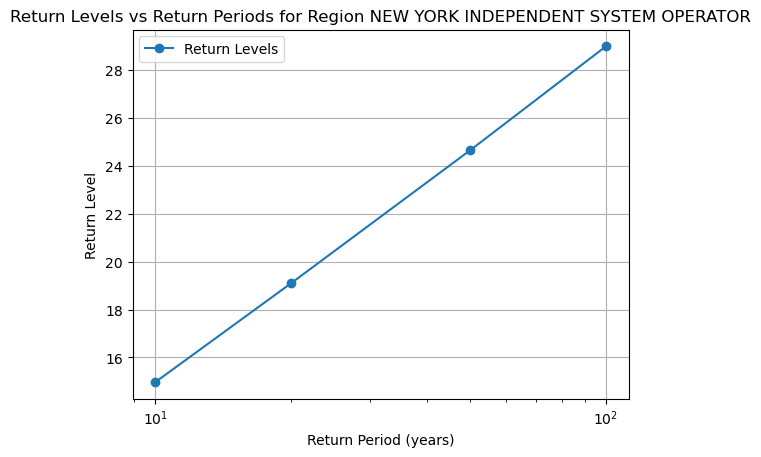

Return Period for region PJM INTERCONNECTION, LLC: 10 years, Return Level: 489.62
Return Period for region PJM INTERCONNECTION, LLC: 20 years, Return Level: 5989.46
Return Period for region PJM INTERCONNECTION, LLC: 50 years, Return Level: 133548.41
Return Period for region PJM INTERCONNECTION, LLC: 100 years, Return Level: 1357701.12


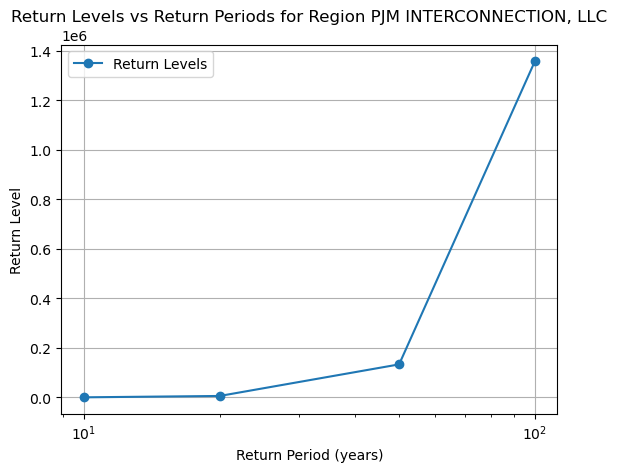

Return Period for region SOUTHERN COMPANY SERVICES, INC.: 10 years, Return Level: 19.47
Return Period for region SOUTHERN COMPANY SERVICES, INC.: 20 years, Return Level: 33.48
Return Period for region SOUTHERN COMPANY SERVICES, INC.: 50 years, Return Level: 63.17
Return Period for region SOUTHERN COMPANY SERVICES, INC.: 100 years, Return Level: 99.00


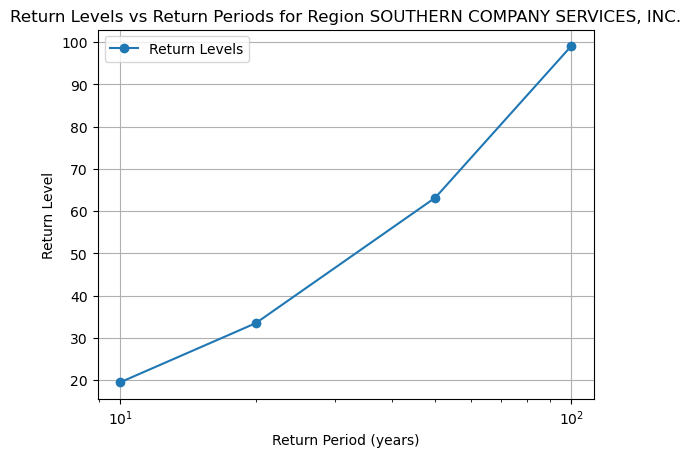

Return Period for region SOUTHWEST POWER POOL: 10 years, Return Level: 13.42
Return Period for region SOUTHWEST POWER POOL: 20 years, Return Level: 18.93
Return Period for region SOUTHWEST POWER POOL: 50 years, Return Level: 27.98
Return Period for region SOUTHWEST POWER POOL: 100 years, Return Level: 36.53


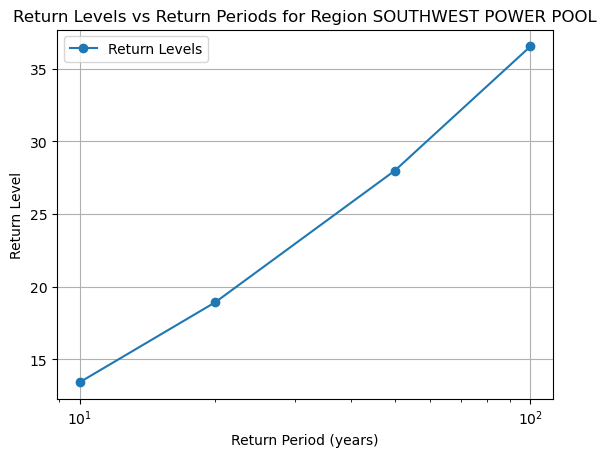

Return Period for region SOUTHWEST POWER POOL WEST: 10 years, Return Level: 32.40
Return Period for region SOUTHWEST POWER POOL WEST: 20 years, Return Level: 32.40
Return Period for region SOUTHWEST POWER POOL WEST: 50 years, Return Level: 32.40
Return Period for region SOUTHWEST POWER POOL WEST: 100 years, Return Level: 32.40


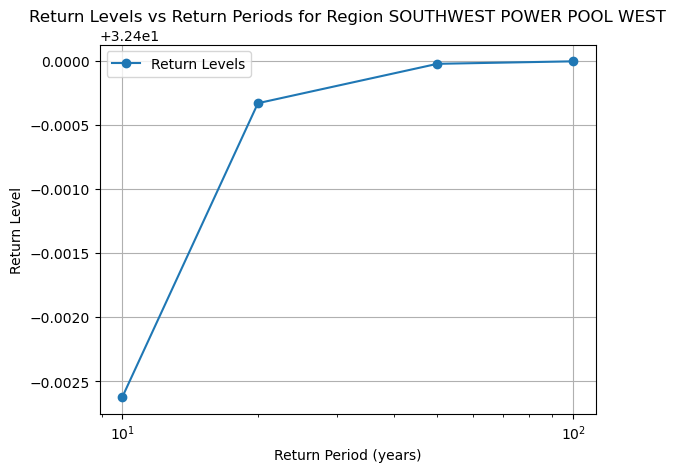

Return Period for region TENNESSEE VALLEY AUTHORITY: 10 years, Return Level: 7.44
Return Period for region TENNESSEE VALLEY AUTHORITY: 20 years, Return Level: 9.94
Return Period for region TENNESSEE VALLEY AUTHORITY: 50 years, Return Level: 13.78
Return Period for region TENNESSEE VALLEY AUTHORITY: 100 years, Return Level: 17.17


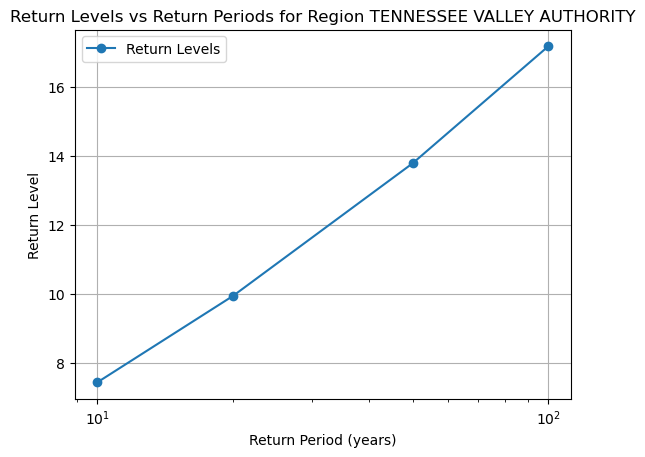

Return Period for region VACAR SOUTH: 10 years, Return Level: 13.34
Return Period for region VACAR SOUTH: 20 years, Return Level: 21.64
Return Period for region VACAR SOUTH: 50 years, Return Level: 38.30
Return Period for region VACAR SOUTH: 100 years, Return Level: 57.38


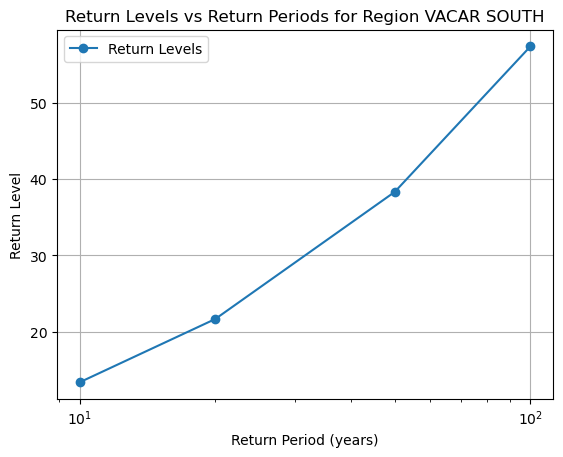

Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 10 years, Return Level: 22.23
Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 20 years, Return Level: 48.44
Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 50 years, Return Level: 132.17
Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 100 years, Return Level: 280.09


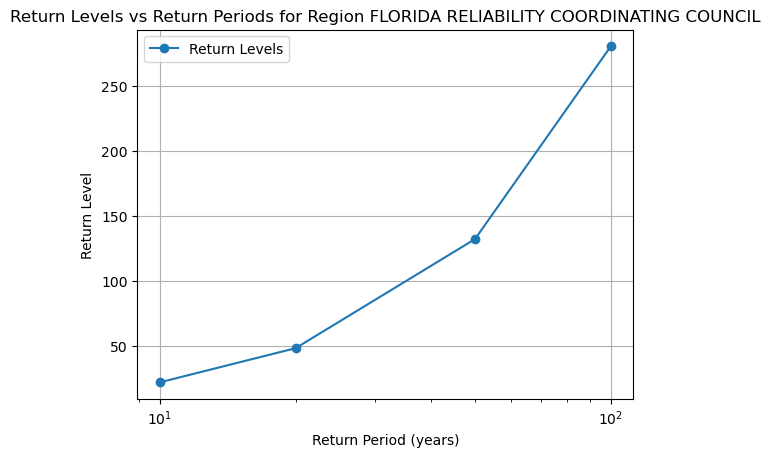

In [104]:
for region, e in extreme_value_fits.items():
    
    # Define return periods (in years)
    return_periods = np.array([10, 20, 50, 100])
    
    # Calculate return levels
    return_levels = genextreme.isf(1 / return_periods, e[0], loc=e[1], scale=e[2])
    
    # Display results
    for rp, rl in zip(return_periods, return_levels):
        print(f"Return Period for region {region}: {rp} years, Return Level: {rl:.2f}")


    plt.figure()
    plt.plot(return_periods, return_levels, marker='o', label='Return Levels')
    plt.title('Return Levels vs Return Periods for Region '+region)
    plt.xlabel('Return Period (years)')
    plt.ylabel('Return Level')
    plt.xscale('log')  # Log scale for better visualization
    plt.grid(True)
    plt.legend()
    plt.show()

<Axes: >

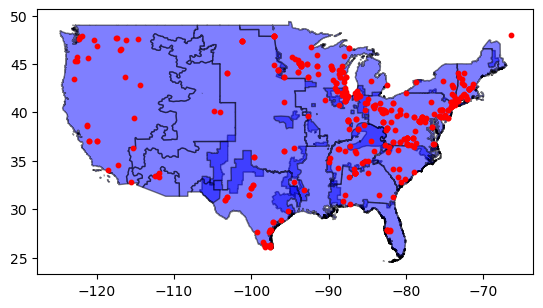

In [62]:
ax = regions_gdf.plot(color="blue", alpha=0.5, edgecolor="black")
sensor_locations_with_regions.plot(ax=ax, color="red", markersize=10)